# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2023 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

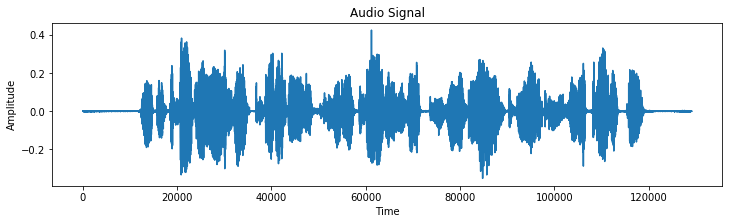

**Shape of Audio Signal** : (129103,)

**Transcript** : mister quilter is the apostle of the middle classes and we are glad to welcome his gospel

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

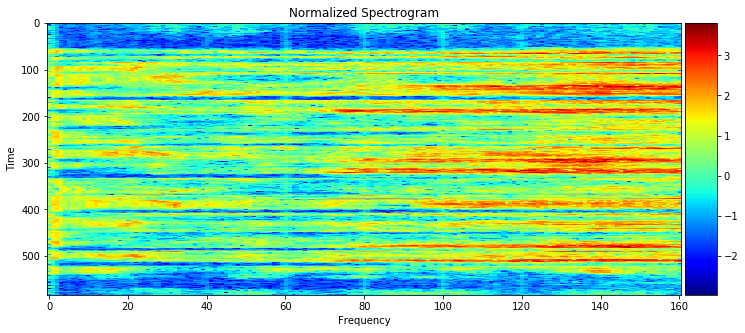

**Shape of Spectrogram** : (584, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

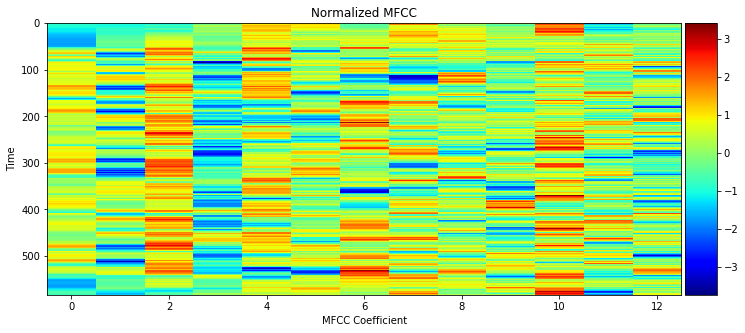

**Shape of MFCC** : (584, 13)

In [7]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.
c:\miniconda2\envs\aind-vui\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.
c:\miniconda2\envs\aind-vui\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.
c:\miniconda2\envs\aind-vui\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [7]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
model_0_mfcc = simple_rnn_model(input_dim=13) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          3741      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [9]:
%%time

train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 106s - loss: 880.2928 - val_loss: 760.2774
Epoch 2/20
101/101 [==============================] - 106s - loss: 780.8457 - val_loss: 756.3770
Epoch 3/20
101/101 [==============================] - 108s - loss: 779.4808 - val_loss: 755.0679
Epoch 4/20
101/101 [==============================] - 108s - loss: 779.7059 - val_loss: 765.9528
Epoch 5/20
101/101 [==============================] - 107s - loss: 779.2846 - val_loss: 766.0179
Epoch 6/20
101/101 [==============================] - 107s - loss: 779.0449 - val_loss: 760.9789
Epoch 7/20
101/101 [==============================] - 107s - loss: 779.5261 - val_loss: 749.4146
Epoch 8/20
101/101 [==============================] - 106s - loss: 779.6360 - val_loss: 757.9719
Epoch 9/20
101/101 [==============================] - 107s - loss: 779.5063 - val_loss: 760.0191
Epoch 10/20
101/101 [==============================] - 107s - loss: 779.5178 - val_loss: 755.8500
Epoch 11/20
101/101 [========

In [13]:
%%time

train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            sort_by_duration=True,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 66s - loss: 778.2072 - val_loss: 750.7201
Epoch 2/20
101/101 [==============================] - 108s - loss: 779.0347 - val_loss: 758.6728
Epoch 3/20
101/101 [==============================] - 108s - loss: 779.1793 - val_loss: 757.0542
Epoch 4/20
101/101 [==============================] - 108s - loss: 778.6553 - val_loss: 754.0560
Epoch 5/20
101/101 [==============================] - 108s - loss: 778.2016 - val_loss: 761.6465
Epoch 6/20
101/101 [==============================] - 107s - loss: 778.6041 - val_loss: 752.7810
Epoch 7/20
101/101 [==============================] - 108s - loss: 778.1173 - val_loss: 751.9464
Epoch 8/20
101/101 [==============================] - 108s - loss: 778.4021 - val_loss: 757.6093
Epoch 9/20
101/101 [==============================] - 108s - loss: 777.7225 - val_loss: 756.2788
Epoch 10/20
101/101 [==============================] - 107s - loss: 778.1120 - val_loss: 754.8498
Epoch 11/20
101/101 [=========

In [10]:
%%time

train_model(input_to_softmax=model_0_mfcc, 
            pickle_path='model_0_mfcc.pickle', 
            save_model_path='model_0_mfcc.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 113s - loss: 837.8433 - val_loss: 756.5069
Epoch 2/20
101/101 [==============================] - 111s - loss: 779.5518 - val_loss: 754.4471
Epoch 3/20
101/101 [==============================] - 110s - loss: 779.6648 - val_loss: 757.7223
Epoch 4/20
101/101 [==============================] - 111s - loss: 779.0935 - val_loss: 759.1762
Epoch 5/20
101/101 [==============================] - 111s - loss: 779.4224 - val_loss: 755.9838
Epoch 6/20
101/101 [==============================] - 110s - loss: 779.0979 - val_loss: 762.7660
Epoch 7/20
101/101 [==============================] - 110s - loss: 778.7940 - val_loss: 749.6654
Epoch 8/20
101/101 [==============================] - 110s - loss: 779.0875 - val_loss: 762.9603
Epoch 9/20
101/101 [==============================] - 109s - loss: 779.3721 - val_loss: 753.4745
Epoch 10/20
101/101 [==============================] - 109s - loss: 778.6455 - val_loss: 753.2530
Epoch 11/20
101/101 [========

In [11]:
%%time

train_model(input_to_softmax=model_0_mfcc, 
            pickle_path='model_0_mfcc.pickle', 
            save_model_path='model_0_mfcc.h5',
            sort_by_duration=True,
            spectrogram=False) # change to False if you would like to use MFCC features


Epoch 1/20
101/101 [==============================] - 78s - loss: 778.2264 - val_loss: 750.6887
Epoch 2/20
101/101 [==============================] - 111s - loss: 779.3970 - val_loss: 758.9593
Epoch 3/20
101/101 [==============================] - 112s - loss: 778.7482 - val_loss: 756.4074
Epoch 4/20
101/101 [==============================] - 110s - loss: 778.5753 - val_loss: 756.4549
Epoch 5/20
101/101 [==============================] - 109s - loss: 778.9556 - val_loss: 759.7347
Epoch 6/20
101/101 [==============================] - 110s - loss: 779.0410 - val_loss: 753.3645
Epoch 7/20
101/101 [==============================] - 110s - loss: 779.1860 - val_loss: 759.6807
Epoch 8/20
101/101 [==============================] - 110s - loss: 779.1952 - val_loss: 754.7802
Epoch 9/20
101/101 [==============================] - 110s - loss: 779.2212 - val_loss: 759.9565
Epoch 10/20
101/101 [==============================] - 110s - loss: 779.3181 - val_loss: 752.1662
Epoch 11/20
101/101 [=========

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [7]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


In [5]:
model_1_mfcc = rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         128400    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 135,029
Trainable params: 134,629
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [8]:
%%time

train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 109s - loss: 295.7821 - val_loss: 233.1136
Epoch 2/20
101/101 [==============================] - 110s - loss: 226.8840 - val_loss: 219.0693
Epoch 3/20
101/101 [==============================] - 110s - loss: 202.9053 - val_loss: 197.5613
Epoch 4/20
101/101 [==============================] - 110s - loss: 182.0877 - val_loss: 176.9353
Epoch 5/20
101/101 [==============================] - 111s - loss: 167.1597 - val_loss: 165.0899
Epoch 6/20
101/101 [==============================] - 111s - loss: 156.5305 - val_loss: 160.9198
Epoch 7/20
101/101 [==============================] - 111s - loss: 149.0353 - val_loss: 154.2045
Epoch 8/20
101/101 [==============================] - 110s - loss: 144.1164 - val_loss: 152.0440
Epoch 9/20
101/101 [==============================] - 112s - loss: 139.5179 - val_loss: 151.2416
Epoch 10/20
101/101 [==============================] - 111s - loss: 137.7063 - val_loss: 146.8832
Epoch 11/20
101/101 [========

In [3]:
%%time
from keras.optimizers import SGD
train_model(input_to_softmax=model_1_mfcc, 
            pickle_path='model_1_mfcc.pickle', 
            save_model_path='model_1_mfcc.h5',
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=8.),
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 116s - loss: 291.2054 - val_loss: 239.8617
Epoch 2/20
101/101 [==============================] - 112s - loss: 223.8273 - val_loss: 226.8645
Epoch 3/20
101/101 [==============================] - 111s - loss: 195.1863 - val_loss: 182.9454
Epoch 4/20
101/101 [==============================] - 111s - loss: 172.4435 - val_loss: 163.3587
Epoch 5/20
101/101 [==============================] - 112s - loss: 158.4430 - val_loss: 156.8103
Epoch 6/20
101/101 [==============================] - 111s - loss: 150.0380 - val_loss: 153.7084
Epoch 7/20
101/101 [==============================] - 111s - loss: 144.4712 - val_loss: 146.9206
Epoch 8/20
101/101 [==============================] - 110s - loss: 139.7075 - val_loss: 140.9908
Epoch 9/20
101/101 [==============================] - 112s - loss: 136.3703 - val_loss: 144.4520
Epoch 10/20
101/101 [==============================] - 111s - loss: 132.6830 - val_loss: 141.9517
Epoch 11/20
101/101 [========

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [9]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [10]:
model_2_mfcc = cnn_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                             filters=200,
                             kernel_size=11, 
                             conv_stride=2,
                             conv_border_mode='valid',
                             units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [12]:
model_2_mfcc = cnn_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                             filters=20,
                             kernel_size=11, 
                             conv_stride=2,
                             conv_border_mode='valid',
                             units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 20)          2880      
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 20)          80        
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         44200     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [10]:
%%time

train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 30s - loss: 245.8146 - val_loss: 213.7542
Epoch 2/20
101/101 [==============================] - 28s - loss: 187.5912 - val_loss: 173.8598
Epoch 3/20
101/101 [==============================] - 28s - loss: 159.1279 - val_loss: 156.1205
Epoch 4/20
101/101 [==============================] - 29s - loss: 145.5969 - val_loss: 146.9044
Epoch 5/20
101/101 [==============================] - 28s - loss: 136.2135 - val_loss: 143.8114
Epoch 6/20
101/101 [==============================] - 28s - loss: 129.3513 - val_loss: 140.3053
Epoch 7/20
101/101 [==============================] - 28s - loss: 123.3003 - val_loss: 136.9259
Epoch 8/20
101/101 [==============================] - 28s - loss: 118.5621 - val_loss: 136.0846
Epoch 9/20
101/101 [==============================] - 28s - loss: 114.3790 - val_loss: 140.1678
Epoch 10/20
101/101 [==============================] - 28s - loss: 111.0188 - val_loss: 132.5961
Epoch 11/20
101/101 [==================

In [11]:
%%time

# model_2_mfcc = cnn_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
#                              filters=200,
#                              kernel_size=11, 
#                              conv_stride=2,
#                              conv_border_mode='valid',
#                              units=200)

train_model(input_to_softmax=model_2_mfcc, 
            pickle_path='model_2_mfcc.pickle', 
            save_model_path='model_2_mfcc.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 51s - loss: 240.6346 - val_loss: 200.2550
Epoch 2/20
101/101 [==============================] - 47s - loss: 184.2732 - val_loss: 170.6179
Epoch 3/20
101/101 [==============================] - 47s - loss: 157.7809 - val_loss: 154.4784
Epoch 4/20
101/101 [==============================] - 47s - loss: 145.5308 - val_loss: 145.9488
Epoch 5/20
101/101 [==============================] - 47s - loss: 137.2206 - val_loss: 141.4718
Epoch 6/20
101/101 [==============================] - 47s - loss: 131.4363 - val_loss: 141.3619
Epoch 7/20
101/101 [==============================] - 47s - loss: 126.4999 - val_loss: 137.5892
Epoch 8/20
101/101 [==============================] - 47s - loss: 123.0197 - val_loss: 136.1382
Epoch 9/20
101/101 [==============================] - 48s - loss: 119.3777 - val_loss: 136.8401
Epoch 10/20
101/101 [==============================] - 47s - loss: 116.2856 - val_loss: 135.4496
Epoch 11/20
101/101 [==================

In [13]:
%%time

# model_2_mfcc = cnn_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
#                              filters=20,
#                              kernel_size=11, 
#                              conv_stride=2,
#                              conv_border_mode='valid',
#                              units=200)

train_model(input_to_softmax=model_2_mfcc, 
            pickle_path='model_2_mfcc.pickle', 
            save_model_path='model_2_mfcc.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 54s - loss: 252.1321 - val_loss: 217.2866
Epoch 2/20
101/101 [==============================] - 47s - loss: 195.2648 - val_loss: 179.1131
Epoch 3/20
101/101 [==============================] - 47s - loss: 169.4828 - val_loss: 163.5703
Epoch 4/20
101/101 [==============================] - 47s - loss: 157.3344 - val_loss: 156.2202
Epoch 5/20
101/101 [==============================] - 47s - loss: 149.9168 - val_loss: 149.2884
Epoch 6/20
101/101 [==============================] - 47s - loss: 145.0165 - val_loss: 146.3179
Epoch 7/20
101/101 [==============================] - 48s - loss: 141.3828 - val_loss: 144.2557
Epoch 8/20
101/101 [==============================] - 48s - loss: 138.7960 - val_loss: 149.3527
Epoch 9/20
101/101 [==============================] - 47s - loss: 136.5781 - val_loss: 140.8081
Epoch 10/20
101/101 [==============================] - 47s - loss: 134.2732 - val_loss: 138.7342
Epoch 11/20
101/101 [==================

In [16]:
%%time

model_2_mfcc = cnn_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                             filters=50,
                             kernel_size=11, 
                             conv_stride=2,
                             conv_border_mode='valid',
                             units=200)

train_model(input_to_softmax=model_2_mfcc, 
            pickle_path='model_2_mfcc.pickle', 
            save_model_path='model_2_mfcc.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 50)          7200      
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 50)          200       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         50200     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [22]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn1 (GRU)                   (None, None, 200)         217200    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
rnn2 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
bn_rnn2 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [35]:
model_3_mfcc = deep_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn1 (GRU)                   (None, None, 200)         128400    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
rnn2 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
bn_rnn2 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [23]:
%%time

train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 213s - loss: 306.8939 - val_loss: 271.1455
Epoch 2/20
101/101 [==============================] - 212s - loss: 225.8315 - val_loss: 200.7021
Epoch 3/20
101/101 [==============================] - 213s - loss: 184.3391 - val_loss: 170.8227
Epoch 4/20
101/101 [==============================] - 212s - loss: 158.9960 - val_loss: 160.2251
Epoch 5/20
101/101 [==============================] - 213s - loss: 146.0489 - val_loss: 146.8691
Epoch 6/20
101/101 [==============================] - 212s - loss: 136.3688 - val_loss: 145.5369
Epoch 7/20
101/101 [==============================] - 211s - loss: 129.2700 - val_loss: 140.4274
Epoch 8/20
101/101 [==============================] - 211s - loss: 123.4933 - val_loss: 138.2180
Epoch 9/20
101/101 [==============================] - 211s - loss: 119.2800 - val_loss: 137.7191
Epoch 10/20
101/101 [==============================] - 211s - loss: 115.5138 - val_loss: 134.2342
Epoch 11/20
101/101 [========

In [25]:
%%time

train_model(input_to_softmax=model_3_mfcc, 
            pickle_path='model_3_mfcc.pickle', 
            save_model_path='model_3_mfcc.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 213s - loss: 316.6387 - val_loss: 236.8987
Epoch 2/20
101/101 [==============================] - 214s - loss: 224.0810 - val_loss: 246.3592
Epoch 3/20
101/101 [==============================] - 214s - loss: 190.9389 - val_loss: 196.6233
Epoch 4/20
101/101 [==============================] - 217s - loss: 169.8076 - val_loss: 166.8998
Epoch 5/20
101/101 [==============================] - 216s - loss: 156.4566 - val_loss: 155.6987
Epoch 6/20
101/101 [==============================] - 215s - loss: 146.8473 - val_loss: 148.9508
Epoch 7/20
101/101 [==============================] - 215s - loss: 140.1890 - val_loss: 143.6738
Epoch 8/20
101/101 [==============================] - 215s - loss: 134.8640 - val_loss: 143.2742
Epoch 9/20
101/101 [==============================] - 214s - loss: 130.3639 - val_loss: 142.2251
Epoch 10/20
101/101 [==============================] - 215s - loss: 127.2166 - val_loss: 138.6686
Epoch 11/20
101/101 [========

In [36]:
%%time

train_model(input_to_softmax=model_3_mfcc, 
            pickle_path='model_3_mfcc.pickle', 
            save_model_path='model_3_mfcc.h5', 
            sort_by_duration=True,
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 133s - loss: 261.2882 - val_loss: 232.1645
Epoch 2/20
101/101 [==============================] - 212s - loss: 222.4462 - val_loss: 220.0011
Epoch 3/20
101/101 [==============================] - 214s - loss: 202.9639 - val_loss: 202.1512
Epoch 4/20
101/101 [==============================] - 215s - loss: 172.4439 - val_loss: 171.6845
Epoch 5/20
101/101 [==============================] - 215s - loss: 154.5073 - val_loss: 158.3432
Epoch 6/20
101/101 [==============================] - 214s - loss: 146.2769 - val_loss: 149.3212
Epoch 7/20
101/101 [==============================] - 215s - loss: 139.3487 - val_loss: 143.4725
Epoch 8/20
101/101 [==============================] - 213s - loss: 134.6586 - val_loss: 145.5901
Epoch 9/20
101/101 [==============================] - 213s - loss: 130.8728 - val_loss: 137.1485
Epoch 10/20
101/101 [==============================] - 213s - loss: 127.1798 - val_loss: 136.4735
Epoch 11/20
101/101 [========

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [29]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidir_rnn (Bidirectional)    (None, None, 400)         434400    
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
model_4_mfcc = bidirectional_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                                       units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidir_rnn (Bidirectional)    (None, None, 400)         256800    
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 268,429
Trainable params: 268,429
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [31]:
%%time

train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 217s - loss: 437.4874 - val_loss: 375.3627
Epoch 2/20
101/101 [==============================] - 221s - loss: 369.4002 - val_loss: 274.8356
Epoch 3/20
101/101 [==============================] - 223s - loss: 240.0082 - val_loss: 212.3260
Epoch 4/20
101/101 [==============================] - 222s - loss: 212.6246 - val_loss: 202.3624
Epoch 5/20
101/101 [==============================] - 221s - loss: 201.4750 - val_loss: 192.3418
Epoch 6/20
101/101 [==============================] - 222s - loss: 192.9164 - val_loss: 185.0233
Epoch 7/20
101/101 [==============================] - 220s - loss: 184.9065 - val_loss: 179.5658
Epoch 8/20
101/101 [==============================] - 223s - loss: 177.8239 - val_loss: 176.9808
Epoch 9/20
101/101 [==============================] - 223s - loss: 170.8309 - val_loss: 172.6357
Epoch 10/20
101/101 [==============================] - 222s - loss: 164.4522 - val_loss: 165.1442
Epoch 11/20
101/101 [========

In [33]:
%%time

train_model(input_to_softmax=model_4_mfcc, 
            pickle_path='model_4_mfcc.pickle', 
            save_model_path='model_4_mfcc.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 224s - loss: 292.3146 - val_loss: 218.5949
Epoch 2/20
101/101 [==============================] - 224s - loss: 213.8638 - val_loss: 200.7317
Epoch 3/20
101/101 [==============================] - 225s - loss: 200.5211 - val_loss: 191.1785
Epoch 4/20
101/101 [==============================] - 224s - loss: 191.0904 - val_loss: 183.6655
Epoch 5/20
101/101 [==============================] - 226s - loss: 183.3746 - val_loss: 178.1911
Epoch 6/20
101/101 [==============================] - 226s - loss: 176.2636 - val_loss: 171.4339
Epoch 7/20
101/101 [==============================] - 227s - loss: 170.1673 - val_loss: 169.6681
Epoch 8/20
101/101 [==============================] - 227s - loss: 164.5996 - val_loss: 161.6339
Epoch 9/20
101/101 [==============================] - 228s - loss: 159.5707 - val_loss: 158.2366
Epoch 10/20
101/101 [==============================] - 229s - loss: 154.8799 - val_loss: 155.5323
Epoch 11/20
101/101 [========

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [2]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

model_5 = bn_input_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                             units=200,
                             activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bn_input (BatchNormalization (None, None, 161)         644       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,673
Trainable params: 223,351
Non-trainable params: 322
_________________________________________________________________
None


In [17]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

model_5_mfcc = bn_input_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                                  units=200,
                                  activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bn_input (BatchNormalization (None, None, 13)          52        
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         128400    
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 134,281
Trainable params: 134,255
Non-trainable params: 26
_________________________________________________________________
None


In [3]:
%%time

train_model(input_to_softmax=model_5, 
            pickle_path='model_5.pickle', 
            save_model_path='model_5.h5', 
            sort_by_duration=True,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 73s - loss: 249.0904 - val_loss: 207.3341
Epoch 2/20
101/101 [==============================] - 117s - loss: 210.4097 - val_loss: 195.7593
Epoch 3/20
101/101 [==============================] - 116s - loss: 195.3261 - val_loss: 187.0366
Epoch 4/20
101/101 [==============================] - 115s - loss: 183.7892 - val_loss: 177.3350
Epoch 5/20
101/101 [==============================] - 117s - loss: 174.6638 - val_loss: 173.2605
Epoch 6/20
101/101 [==============================] - 115s - loss: 166.8488 - val_loss: 167.8006
Epoch 7/20
101/101 [==============================] - 117s - loss: 159.7171 - val_loss: 161.7827
Epoch 8/20
101/101 [==============================] - 116s - loss: 153.2425 - val_loss: 159.7749
Epoch 9/20
101/101 [==============================] - 117s - loss: 147.7376 - val_loss: 152.6699
Epoch 10/20
101/101 [==============================] - 116s - loss: 143.4528 - val_loss: 152.4455
Epoch 11/20
101/101 [=========

In [18]:
%%time

train_model(input_to_softmax=model_5_mfcc, 
            pickle_path='model_5_mfcc.pickle', 
            save_model_path='model_5_mfcc.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 119s - loss: 274.5021 - val_loss: 211.8313
Epoch 2/20
101/101 [==============================] - 119s - loss: 212.0920 - val_loss: 195.9750
Epoch 3/20
101/101 [==============================] - 119s - loss: 196.6611 - val_loss: 188.0521
Epoch 4/20
101/101 [==============================] - 118s - loss: 186.2063 - val_loss: 179.7192
Epoch 5/20
101/101 [==============================] - 120s - loss: 177.6976 - val_loss: 171.6881
Epoch 6/20
101/101 [==============================] - 120s - loss: 170.0021 - val_loss: 165.3539
Epoch 7/20
101/101 [==============================] - 119s - loss: 163.1332 - val_loss: 159.2418
Epoch 8/20
101/101 [==============================] - 119s - loss: 157.1348 - val_loss: 156.6996
Epoch 9/20
101/101 [==============================] - 119s - loss: 152.5608 - val_loss: 153.0703
Epoch 10/20
101/101 [==============================] - 119s - loss: 148.4050 - val_loss: 149.6535
Epoch 11/20
101/101 [========

In [2]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

model_6 = deep_bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                       units=200,
                                       recur_layers=2,
                                       activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidir_rnn1 (Bidirectional)   (None, None, 400)         434400    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
bidir_rnn2 (Bidirectional)   (None, None, 400)         721200    
_________________________________________________________________
bn_rnn2 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [2]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

model_6_mfcc = deep_bidirectional_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                                            units=200,
                                            recur_layers=4,
                                            activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidir_rnn1 (Bidirectional)   (None, None, 400)         256800    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
bidir_rnn2 (Bidirectional)   (None, None, 400)         721200    
_________________________________________________________________
bn_rnn2 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
bidir_rnn3 (Bidirectional)   (None, None, 400)         721200    
_________________________________________________________________
bn_rnn3 (BatchNormalization) (None, None, 400)         1600      
__________

In [3]:
%%time
from keras.optimizers import SGD
train_model(input_to_softmax=model_6, 
            pickle_path='model_6.pickle', 
            save_model_path='model_6.h5', 
            optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5.),
            sort_by_duration=True,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 275s - loss: 283.2435 - val_loss: 273.2311
Epoch 2/20
101/101 [==============================] - 458s - loss: 240.2107 - val_loss: 219.3535
Epoch 3/20
101/101 [==============================] - 462s - loss: 210.6792 - val_loss: 204.6211
Epoch 4/20
101/101 [==============================] - 464s - loss: 184.8029 - val_loss: 192.6222
Epoch 5/20
101/101 [==============================] - 462s - loss: 168.7141 - val_loss: 168.2256
Epoch 6/20
101/101 [==============================] - 461s - loss: 156.4351 - val_loss: 158.5658
Epoch 7/20
101/101 [==============================] - 461s - loss: 145.6156 - val_loss: 147.9509
Epoch 8/20
101/101 [==============================] - 469s - loss: 137.0713 - val_loss: 145.5261
Epoch 9/20
101/101 [==============================] - 462s - loss: 129.7674 - val_loss: 139.2968
Epoch 10/20
101/101 [==============================] - 458s - loss: 124.0467 - val_loss: 136.0033
Epoch 11/20
101/101 [========

In [5]:
%%time
from keras.optimizers import SGD
train_model(input_to_softmax=model_6, 
            pickle_path='model_6_mb32.pickle', 
            save_model_path='model_6_mb32.h5', 
            minibatch_size=32,
            optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5.),
            sort_by_duration=True,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
63/63 [==============================] - 171s - loss: 227.9032 - val_loss: 217.4157
Epoch 2/20
63/63 [==============================] - 292s - loss: 222.8523 - val_loss: 212.6629
Epoch 3/20
63/63 [==============================] - 295s - loss: 212.7539 - val_loss: 207.4203
Epoch 4/20
63/63 [==============================] - 294s - loss: 202.7801 - val_loss: 208.2089
Epoch 5/20
63/63 [==============================] - 296s - loss: 189.8309 - val_loss: 191.5831
Epoch 6/20
63/63 [==============================] - 293s - loss: 175.6987 - val_loss: 191.2326
Epoch 7/20
63/63 [==============================] - 294s - loss: 162.9805 - val_loss: 180.8957
Epoch 8/20
63/63 [==============================] - 293s - loss: 152.9737 - val_loss: 157.4005
Epoch 9/20
63/63 [==============================] - 296s - loss: 144.3327 - val_loss: 147.5761
Epoch 10/20
63/63 [==============================] - 295s - loss: 138.2733 - val_loss: 142.9618
Epoch 11/20
63/63 [==============================

In [3]:
%%time

train_model(input_to_softmax=model_6_mfcc, 
            pickle_path='model_6_mfcc_mb32.pickle', 
            save_model_path='model_6_mfcc_mb32.h5', 
            minibatch_size=32,
            sort_by_duration=True,
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
63/63 [==============================] - 393s - loss: 268.6019 - val_loss: 329.4318
Epoch 2/20
63/63 [==============================] - 641s - loss: 224.9603 - val_loss: 234.7361
Epoch 3/20
63/63 [==============================] - 638s - loss: 205.9093 - val_loss: 222.6180
Epoch 4/20
63/63 [==============================] - 636s - loss: 184.3038 - val_loss: 215.1371
Epoch 5/20
63/63 [==============================] - 632s - loss: 165.0344 - val_loss: 192.5443
Epoch 6/20
63/63 [==============================] - 630s - loss: 149.7693 - val_loss: 160.3196
Epoch 7/20
63/63 [==============================] - 631s - loss: 138.1062 - val_loss: 146.4152
Epoch 8/20
63/63 [==============================] - 628s - loss: 126.4019 - val_loss: 140.2940
Epoch 9/20
63/63 [==============================] - 639s - loss: 117.6210 - val_loss: 132.8184
Epoch 10/20
63/63 [==============================] - 630s - loss: 111.6031 - val_loss: 130.2547
Epoch 11/20
63/63 [==============================

In [2]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

model_7 = deep_bidirectional_rnn_model_lessmem_dropout(input_dim=161, # change to 13 if you would like to use MFCC features
                                        units=200,
                                        recur_layers=2,
                                        dropout=0.25, 
                                        recurrent_dropout=0.25,
                                        activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidir_rnn1 (Bidirectional)   (None, None, 400)         434400    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
bidir_rnn2 (Bidirectional)   (None, None, 400)         721200    
_________________________________________________________________
bn_rnn2 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
time_dense (TimeDistributed) (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [11]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

model_7_mfcc = deep_bidirectional_rnn_model_lessmem_dropout(input_dim=13, # change to 13 if you would like to use MFCC features
                                        units=50,
                                        recur_layers=4,
                                        dropout=0.25, 
                                        recurrent_dropout=0.25,
                                        activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidir_rnn1 (Bidirectional)   (None, None, 400)         256800    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
bidir_rnn2 (Bidirectional)   (None, None, 400)         721200    
_________________________________________________________________
bn_rnn2 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
bidir_rnn3 (Bidirectional)   (None, None, 400)         721200    
_________________________________________________________________
bn_rnn3 (BatchNormalization) (None, None, 400)         1600      
__________

In [6]:
%%time
from keras.optimizers import SGD
train_model(input_to_softmax=model_7, 
            pickle_path='model_7_mb32.pickle', 
            save_model_path='model_7_mb32.h5', 
            minibatch_size=32,
            optimizer=SGD(lr=0.02, decay=1e-4, momentum=0.9, nesterov=True, clipnorm=5.),
            sort_by_duration=True,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
63/63 [==============================] - 180s - loss: 311.0170 - val_loss: 350.3254
Epoch 2/20
63/63 [==============================] - 304s - loss: 253.0011 - val_loss: 245.8058
Epoch 3/20
63/63 [==============================] - 308s - loss: 237.6422 - val_loss: 215.1832
Epoch 4/20
63/63 [==============================] - 311s - loss: 224.9245 - val_loss: 206.8164
Epoch 5/20
63/63 [==============================] - 312s - loss: 209.8870 - val_loss: 193.0997
Epoch 6/20
63/63 [==============================] - 311s - loss: 197.2126 - val_loss: 179.3186
Epoch 7/20
63/63 [==============================] - 310s - loss: 185.1848 - val_loss: 170.8569
Epoch 8/20
63/63 [==============================] - 310s - loss: 174.8758 - val_loss: 164.6944
Epoch 9/20
63/63 [==============================] - 310s - loss: 166.7022 - val_loss: 152.0403
Epoch 10/20
63/63 [==============================] - 309s - loss: 159.8143 - val_loss: 147.1797
Epoch 11/20
63/63 [==============================

In [3]:
%%time
from keras.optimizers import SGD
train_model(input_to_softmax=model_7, 
            pickle_path='model_7_mb32_e50.pickle', 
            save_model_path='model_7_mb32_e50.h5', 
            minibatch_size=32,
            epochs=50,
            optimizer=SGD(lr=0.02, decay=1e-4, momentum=0.9, nesterov=True, clipnorm=5.),
            sort_by_duration=True,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/50
63/63 [==============================] - 195s - loss: 312.4374 - val_loss: 332.8485
Epoch 2/50
63/63 [==============================] - 308s - loss: 254.5500 - val_loss: 256.4984
Epoch 3/50
63/63 [==============================] - 311s - loss: 239.7889 - val_loss: 226.2843
Epoch 4/50
63/63 [==============================] - 306s - loss: 221.0908 - val_loss: 201.3257
Epoch 5/50
63/63 [==============================] - 306s - loss: 207.3018 - val_loss: 189.5693
Epoch 6/50
63/63 [==============================] - 306s - loss: 193.9087 - val_loss: 175.5997
Epoch 7/50
63/63 [==============================] - 307s - loss: 181.4540 - val_loss: 163.8762
Epoch 8/50
63/63 [==============================] - 308s - loss: 172.1547 - val_loss: 158.5518
Epoch 9/50
63/63 [==============================] - 308s - loss: 164.8896 - val_loss: 151.0119
Epoch 10/50
63/63 [==============================] - 307s - loss: 158.7551 - val_loss: 145.9629
Epoch 11/50
63/63 [==============================

In [3]:
%%time
from keras.optimizers import SGD
train_model(input_to_softmax=model_7, 
            pickle_path='model_7_100_mb32_e50.pickle', 
            save_model_path='model_7_100_mb32_e50.h5', 
            train_json='train_100_corpus.json',
            minibatch_size=32,
            epochs=50,
            optimizer=SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True, clipnorm=5.),
            sort_by_duration=True,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/50
162/162 [==============================] - 464s - loss: 287.7963 - val_loss: 230.5232
Epoch 2/50
162/162 [==============================] - 720s - loss: 262.6577 - val_loss: 220.8409
Epoch 3/50
162/162 [==============================] - 721s - loss: 251.2835 - val_loss: 206.9825
Epoch 4/50
162/162 [==============================] - 726s - loss: 235.3516 - val_loss: 193.9477
Epoch 5/50
162/162 [==============================] - 724s - loss: 218.7090 - val_loss: 175.0028
Epoch 6/50
162/162 [==============================] - 726s - loss: 202.7590 - val_loss: 167.7344
Epoch 7/50
162/162 [==============================] - 718s - loss: 188.8623 - val_loss: 156.8745
Epoch 8/50
162/162 [==============================] - 719s - loss: 179.2861 - val_loss: 151.5038
Epoch 9/50
162/162 [==============================] - 721s - loss: 172.4172 - val_loss: 145.2620
Epoch 10/50
162/162 [==============================] - 724s - loss: 167.3724 - val_loss: 143.1192
Epoch 11/50
162/162 [========

In [12]:
%%time
from keras.optimizers import SGD
train_model(input_to_softmax=model_7_mfcc, 
            pickle_path='model_7_mfcc_mb32.pickle', 
            save_model_path='model_7_mfcc_mb32.h5', 
            minibatch_size=32,
            optimizer=SGD(lr=0.02, decay=1e-4, momentum=0.9, nesterov=True, clipnorm=5.),
            sort_by_duration=True,
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
63/63 [==============================] - 376s - loss: 336.6613 - val_loss: 237.8393
Epoch 2/20
63/63 [==============================] - 608s - loss: 241.4074 - val_loss: 220.1242
Epoch 3/20
63/63 [==============================] - 610s - loss: 230.9872 - val_loss: 221.7488
Epoch 4/20
63/63 [==============================] - 626s - loss: 226.8863 - val_loss: 214.1814
Epoch 5/20
63/63 [==============================] - 623s - loss: 221.9829 - val_loss: 211.6896
Epoch 6/20
63/63 [==============================] - 620s - loss: 214.6298 - val_loss: 207.9072
Epoch 7/20
63/63 [==============================] - 617s - loss: 443.8520 - val_loss: 402.7747
Epoch 8/20
63/63 [==============================] - 620s - loss: 450.3242 - val_loss: 458.5856
Epoch 9/20
63/63 [==============================] - 623s - loss: 449.8299 - val_loss: 526.3692
Epoch 10/20
63/63 [==============================] - 620s - loss: 447.6906 - val_loss: 581.2701
Epoch 11/20
63/63 [==============================

In [2]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

model_8 = dilated_cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                filters=128,
                                kernel_size=11, 
                                conv_border_mode='causal',
                                conv_layers=3,
                                dropout=0.25, 
                                recurrent_dropout=0.25,
                                units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 128)         226816    
_________________________________________________________________
cnn_dropout1 (Dropout)       (None, None, 128)         0         
_________________________________________________________________
bn_conv1d1 (BatchNormalizati (None, None, 128)         512       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 128)         180352    
_________________________________________________________________
cnn_dropout2 (Dropout)       (None, None, 128)         0         
_________________________________________________________________
bn_conv1d2 (BatchNormalizati (None, None, 128)         512       
__________

In [4]:
### Feel free to use as many code cells as needed.

model_8_mfcc = dilated_cnn_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                                     filters=50,
                                     kernel_size=11, 
                                     conv_border_mode='valid',
                                     conv_layers=3,
                                     dropout=0.25, 
                                     recurrent_dropout=0.25,
                                     units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 50)          7200      
_________________________________________________________________
cnn_dropout1 (Dropout)       (None, None, 50)          0         
_________________________________________________________________
bn_conv1d1 (BatchNormalizati (None, None, 50)          200       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 50)          27550     
_________________________________________________________________
cnn_dropout2 (Dropout)       (None, None, 50)          0         
_________________________________________________________________
bn_conv1d2 (BatchNormalizati (None, None, 50)          200       
__________

In [3]:
%%time
from keras.optimizers import SGD
train_model(input_to_softmax=model_8, 
            pickle_path='model_8_mb32.pickle', 
            save_model_path='model_8_mb32.h5', 
            minibatch_size=32,
            epochs=20,
            optimizer=SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True, clipnorm=8.),
            sort_by_duration=True,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
63/63 [==============================] - 66s - loss: 301.4377 - val_loss: 475.6932
Epoch 2/20
63/63 [==============================] - 93s - loss: 248.3847 - val_loss: 241.0496
Epoch 3/20
63/63 [==============================] - 89s - loss: 238.6960 - val_loss: 226.8527
Epoch 4/20
63/63 [==============================] - 88s - loss: 235.6313 - val_loss: 221.0737
Epoch 5/20
63/63 [==============================] - 88s - loss: 226.4612 - val_loss: 213.3369
Epoch 6/20
63/63 [==============================] - 89s - loss: 218.4198 - val_loss: 208.7777
Epoch 7/20
63/63 [==============================] - 89s - loss: 203.5804 - val_loss: 194.3569
Epoch 8/20
63/63 [==============================] - 89s - loss: 187.2461 - val_loss: 177.7415
Epoch 9/20
63/63 [==============================] - 89s - loss: 174.5014 - val_loss: 167.2492
Epoch 10/20
63/63 [==============================] - 90s - loss: 165.8874 - val_loss: 156.4834
Epoch 11/20
63/63 [==============================] - 88s - 

In [5]:
%%time
from keras.optimizers import SGD
train_model(input_to_softmax=model_8_mfcc, 
            pickle_path='model_8_mfcc_mb32.pickle', 
            save_model_path='model_8_mfcc_mb32.h5', 
            minibatch_size=32,
            optimizer=SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True, clipnorm=5.),
            sort_by_duration=True,
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
63/63 [==============================] - 84s - loss: 297.9048 - val_loss: 328.3569
Epoch 2/20
63/63 [==============================] - 91s - loss: 235.0804 - val_loss: 226.3048
Epoch 3/20
63/63 [==============================] - 88s - loss: 227.4395 - val_loss: 214.0834
Epoch 4/20
63/63 [==============================] - 88s - loss: 222.6437 - val_loss: 211.8805
Epoch 5/20
63/63 [==============================] - 88s - loss: 219.3651 - val_loss: 208.6759
Epoch 6/20
63/63 [==============================] - 88s - loss: 216.8019 - val_loss: 207.7069
Epoch 7/20
63/63 [==============================] - 88s - loss: 213.9178 - val_loss: 205.0857
Epoch 8/20
63/63 [==============================] - 87s - loss: 210.9110 - val_loss: 202.2409
Epoch 9/20
63/63 [==============================] - 88s - loss: 207.6104 - val_loss: 199.2812
Epoch 10/20
63/63 [==============================] - 88s - loss: 203.6029 - val_loss: 192.2868
Epoch 11/20
63/63 [==============================] - 87s - 

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

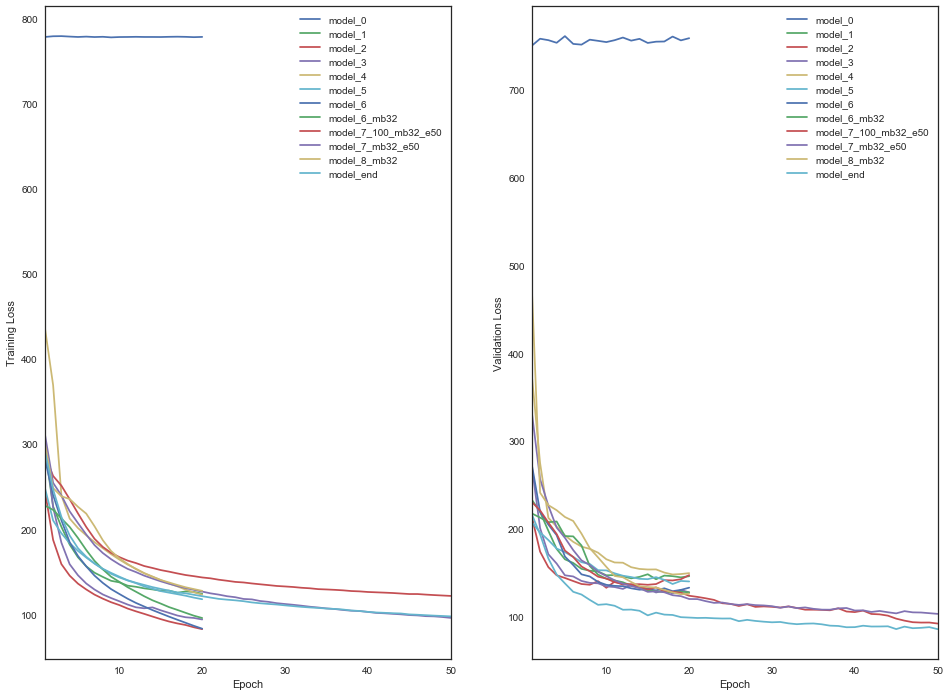

In [4]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,12))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

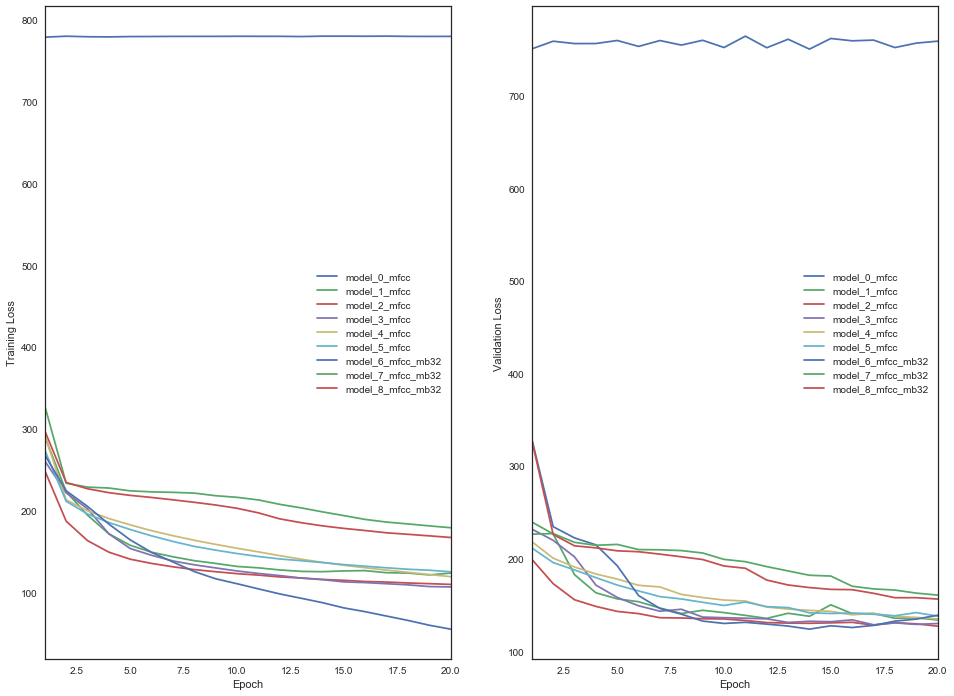

In [5]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/mfcc/*.pickle"))
# extract the name of each model
model_names = [item[13:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,12))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__

**model_0 (single layer RNN)** showed poor performance with high training and validation losses above 750 after 20 epochs of training. This model probably does not have enough complexity to model the relationship between the spectrogram input and the text labels.

**model_1 (single layer RNN with Batch Normalization and Time Distributed Dense Layer)** showed decreasing training and validation losses, achieving training and validation losses below 150 after 20 epochs. The batch normalization probably helped in faster convergence and the addition of the time distributed dense layers at each time step added complexity to the model to enable it to learn the relationship between the inputs and the labels.

**model_2 (single layer CNN + single layer RNN with Batch Normalization and Time Distributed Dense Layer)** displayed lower training and validation losses compared to model_1 after 20 epochs, however with spectrogram inputs, it started overfitting after about 10 epochs, while with MFCC inputs, it showed improving validation losses below 130 after 20 epochs.

**model_3 (two layers RNN with Batch Normalization and Time Distributed Dense Layer)** showed better validation losses compared to model_2 after 20 epochs, scoring 130 for spectrogram and below 128 for MFCC inputs. There isn't overfitting within 20 epochs.

**model_4 (single stack bidirectional RNN with Batch Normalization and Time Distributed Dense Layer)** had worse training and validation losses compared to model_2, scoring about 149 validation loss for spectrogram, and 135 for MFCC after 20 epochs. Compared to model_1 however, it performed better, suggesting there is an advantage in having a bidirectional architecture which is able to extract future and past context from the utterance at each time step. 

**model_5 (single layer RNN with Batch Normalization on input only and Time Distributed Dense Layer)** showed lower training and validation losses at the first epoch, compared to model_1, however the rate of convergence dropped with subsequent epochs and it ended up with higher validation loss of 139 after 20 epochs. This showed that for this case, having batch normalisation on the recurrent network layer is more advantageous than having it on the input layer.

**model_6 (two stacks bidirectional RNN with Batch Normalization and Time Distributed Dense Layer)** showed lower training and validation losses compared to model_4, attaining validation loss of 132 after 20 epochs with spectrogram inputs. This shows having two bidirectional layers is more advantageous to having one, and the model has greater capacity to learn the relationship between inputs and labels. However we also see that the training loss dips to 83 and the model appears to begin overfitting after 18 epochs. With MFCC inputs, the model was tested with 4 layers and showed overfitting after 14 epochs.

**model_7 (two stacks bidirectional RNN with Dropout, Batch Normalization and Time Distributed Dense Layer)** with the added dropout showed less overfitting compared to model_6, getting a training loss of 126 and validation loss of 119 with spectrogram inputs after 20 epochs, and finally attaining a validation loss of 102 after 50 epochs. This model was also trained on the `train-clean-100` dataset, and got a validation loss of 91 after 50 epochs.

**model_8 (three layer CNN with Dilated Convolutions, Dropout, Batch Normalization and Time Distributed Dense Layer)** compared to the single layer CNN model_2 had worse training and validation losses after 10 epochs. However after 20 epochs, it attained a lower validation loss of 125.

Out of the above models, the deep bidirectional RNN with dropout (**model_7**) showed the best performance. This model appears to have sufficient capacity to learn the relationship between spectrogram inputs and transcribed text outputs, and dropout to reduce overfitting.

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [2]:
# specify the model
model_end = final_model(input_dim=161, 
                        units=200, 
                        filters=200, 
                        kernel_size=11, 
                        conv_border_mode='valid',
                        conv_layers=3, 
                        recur_layers=2, 
                        activation='relu', 
                        dropout=0.25, 
                        recurrent_dropout=0.25, 
                        output_dim=29)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
cnn_dropout1 (Dropout)       (None, None, 200)         0         
_________________________________________________________________
bn_conv1d1 (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
cnn_dropout2 (Dropout)       (None, None, 200)         0         
_________________________________________________________________
bn_conv1d2 (BatchNormalizati (None, None, 200)         800       
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [ ]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

In [3]:
%%time
from keras.optimizers import SGD
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
#             train_json='train_100_corpus.json',
            minibatch_size=32,
            epochs=50,
            optimizer=SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True, clipnorm=5.),
            sort_by_duration=True,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/50
63/63 [==============================] - 196s - loss: 314.8814 - val_loss: 302.8011
Epoch 2/50
63/63 [==============================] - 323s - loss: 242.9642 - val_loss: 228.1481
Epoch 3/50
63/63 [==============================] - 311s - loss: 232.0366 - val_loss: 223.5764
Epoch 4/50
63/63 [==============================] - 307s - loss: 227.7679 - val_loss: 217.1002
Epoch 5/50
63/63 [==============================] - 305s - loss: 223.7637 - val_loss: 214.3809
Epoch 6/50
63/63 [==============================] - 308s - loss: 220.2009 - val_loss: 212.0846
Epoch 7/50
63/63 [==============================] - 304s - loss: 217.2950 - val_loss: 207.3155
Epoch 8/50
63/63 [==============================] - 306s - loss: 214.3515 - val_loss: 205.9793
Epoch 9/50
63/63 [==============================] - 305s - loss: 210.3180 - val_loss: 199.7778
Epoch 10/50
63/63 [==============================] - 304s - loss: 205.5639 - val_loss: 190.9749
Epoch 11/50
63/63 [==============================

In [3]:
%%time
from keras.optimizers import SGD
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            train_json='train_100_corpus.json',
            minibatch_size=32,
            epochs=50,
            optimizer=SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True, clipnorm=5.),
            sort_by_duration=True,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/50
162/162 [==============================] - 490s - loss: 291.8355 - val_loss: 216.4753
Epoch 2/50
162/162 [==============================] - 735s - loss: 246.7555 - val_loss: 193.4916
Epoch 3/50
162/162 [==============================] - 724s - loss: 214.6455 - val_loss: 166.0237
Epoch 4/50
162/162 [==============================] - 724s - loss: 192.7451 - val_loss: 147.6635
Epoch 5/50
162/162 [==============================] - 723s - loss: 177.8286 - val_loss: 137.6298
Epoch 6/50
162/162 [==============================] - 725s - loss: 167.7780 - val_loss: 128.0433
Epoch 7/50
162/162 [==============================] - 734s - loss: 159.9238 - val_loss: 124.9206
Epoch 8/50
162/162 [==============================] - 744s - loss: 153.6656 - val_loss: 118.8093
Epoch 9/50
162/162 [==============================] - 741s - loss: 148.8329 - val_loss: 113.1810
Epoch 10/50
162/162 [==============================] - 737s - loss: 144.3776 - val_loss: 113.9109
Epoch 11/50
162/162 [========

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__

Final model architecture uses a combination of multi layer CNNs (convolutional neural nets) with multi layer bidirectional RNNs (recurrent neural nets). The input feeds into `3` 1-dimensional convolution layers with `200` filters and kernel size of `11`, with dilation rates of `1`, `2` and `4` for the first, second and third CNN layers respectively. Dilated convolutions might be able to capture information from a larger receptive field in the lower layers and model longer range dependencies in the data. The earlier experiment above with **model_8** with 3 dilated convolution layers seems to offer some promise. 

The output of the 3rd CNN layer is then fed into 2 layers of bidirectional RNNs, using `200` GRU (gated recurrent unit) cells for each direction per layer, for a total of `400` GRU  cells for each layer. The earlier experiments with **model_6** and **model_7** showed that deep bidirectional RNNs seem to have the capacity to model the relationship between the spectrogram inputs and their transcribed text labels, squeezing more information from the past and future context at each timestep of the utterance. 

Dropout of `0.25` and batch normalization is applied after each CNN layer and similarly RNN input dropout of `0.25` and recurrent droput of `0.25` is applied to each RNN layer. Batch normalization is also applied after each bidirectional RNN layer. Dropout is used to reduce model overfitting by forcing the model not to depend on certain pathways. Batch normalization seems to help speed up model convergence. 

Time distributed dense layers with `29` units to map to the output characters (26 letters plus space, apostrophe and blank) are added to each RNN timestep to tease out more complex patterns in the data. Finally softmax activation is applied on the dense layers to obtain the predictions for the output characters.

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [6]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio, display

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    display(Audio(audio_path))
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [7]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(), 
                model_path='results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
cnn_dropout1 (Dropout)       (None, None, 200)         0         
_________________________________________________________________
bn_conv1d1 (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
cnn_dropout2 (Dropout)       (None, None, 200)         0         
_________________________________________________________________
bn_conv1d2 (BatchNormalizati (None, None, 200)         800       
__________

True transcription:

mister quilter is the apostle of the middle classes and we are glad to welcome his gospel
--------------------------------------------------------------------------------
Predicted transcription:

this te culteris he applosoo of the mitel clases and werblelaad tolokm his gosble
--------------------------------------------------------------------------------


Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [8]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(), 
                model_path='results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
cnn_dropout1 (Dropout)       (None, None, 200)         0         
_________________________________________________________________
bn_conv1d1 (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
cnn_dropout2 (Dropout)       (None, None, 200)         0         
_________________________________________________________________
bn_conv1d2 (BatchNormalizati (None, None, 200)         800       
__________

True transcription:

stuff it into you his belly counselled him
--------------------------------------------------------------------------------
Predicted transcription:

stoffed in to you his bely counald him
--------------------------------------------------------------------------------


One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!